# Development and Testing Notebook

## Strategy Development

### Available data

In [1]:
import os
from pathlib import Path
import options_wizard as ow
from dotenv import load_dotenv
load_dotenv()
tick_path = os.getenv("TICK_PATH", "").split(os.pathsep)[0]

p = Path(tick_path)
if p.is_dir(): 
    available_ticks =[f.name.replace('.parquet', '') for f in p.iterdir() if f.is_file()]

n_const = 10
start_date = ow.DateObj(2010, 1, 1)
end_date = ow.DateObj(2020, 12, 31)

universe = ow.Universe()
universe.top_constituents(n_const)

In [ ]:
import polars as pl
from operator import ne, le, eq

pipeline = ow.Pipeline(universe=universe, saves=ow.SaveFrames.STRAT)
kwargs = {
    'max_date': end_date.to_pl(),
    'keep_col' : ['call_put', 'ttm', 'n_missing'],
    'keep_oper': [eq, le, le],
    'keep_val': ['p', 120, 0],
    'delta_otm': 0.10,
    'delta_atm': 0.35,
    'hold_period': 30,
    'otm_ratio': 2,
    'num_const': n_const,
    }

ow.add_put_spread_methods(pipeline, kwargs)

pipeline.run()

  0%|          | 0/26 [00:00<?, ?it/s]

 42%|████▏     | 11/26 [02:13<02:46, 11.12s/it]

## Backtesting the Strategy

### Building trades from outputs

In [ ]:
import options_wizard as ow
from tqdm import tqdm
from functools import partial


start_cash = 1_000_000

ptf = partial(ow.Trade, transaction_cost_model=ow.TransactionCostModel.SPREAD, accounting_type=ow.AccountingConvention.MTM)
cfg = ow.BackTestConfig(
    starting_cash = start_cash,
    start_date=start_date,
    end_date=end_date
)
position = ow.FixedHold1MnNotional(cfg)

for tick in tqdm(universe.ticks):
    strat = ow.StratType.load(tick=tick)
    trade = strat.reconstruct(wrapper = ptf)
    position.add_trade(trade)

100%|██████████| 26/26 [00:00<00:00, 26252.26it/s]


### Running the Backtest

In [ ]:
result = ow.BackTestCoordinator(
    position = position,
    dates = ow.market_dates(start_date, end_date, exchange=ow.Exchange.NASDAQ),
    debug = True
).run()

100%|██████████| 2769/2769 [00:00<00:00, 345912.96it/s]


Text(0, 0.5, 'Total Equity $')

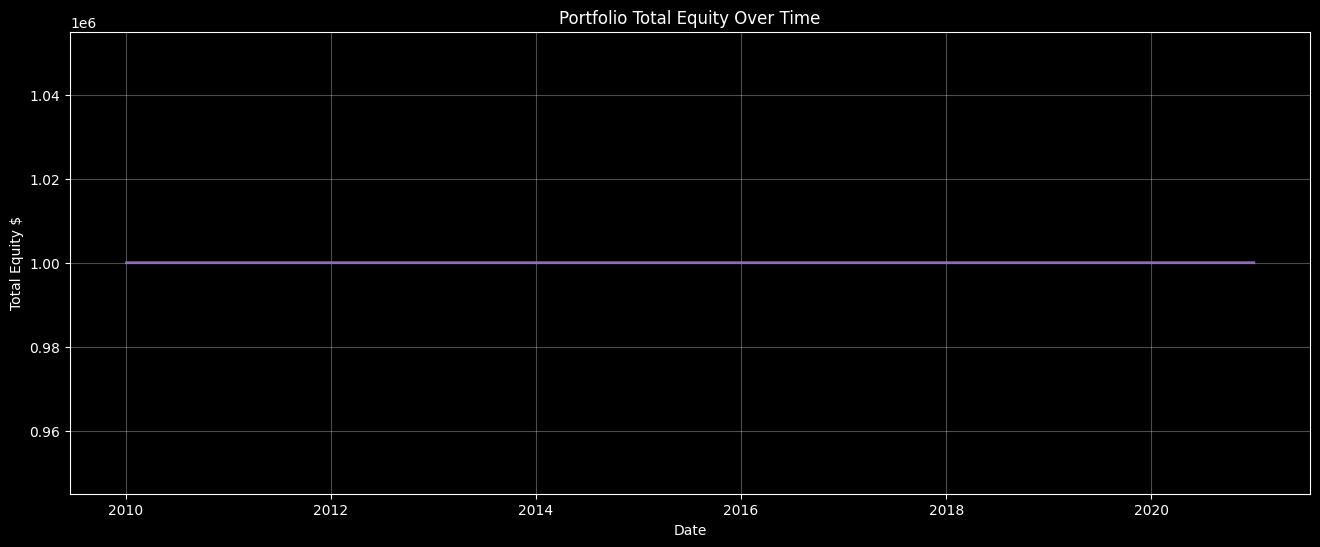

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotx as mx
import numpy as np
from statistics import mean

mpl.style.use("dark_background")

def plot_entry_strikes_lines(backtest_result, ticks):
    """
    Plot entered option strikes over time as separate long/short lines,
    alongside the underlying close series. Returns (fig, ax).
    """
    trades = set()
    for snap in backtest_result.snapshots:
        trades.update(snap.trade_equities.keys())

    def norm_side(pos):
        if pos is None:
            return "unknown"
        if hasattr(pos, "value"):
            return str(pos.value).lower()
        s = str(pos).lower()
        if "long" in s:
            return "long"
        if "short" in s:
            return "short"
        return s

    long_strikes, short_strikes, underlying_series = {}, {}, {}

    for trade in trades:
        entry_date = trade.entry_data.entry_date
        px = trade.entry_data.price_series.get(entry_date)
        if px is None:
            continue

        side = norm_side(trade.entry_data.position_type)
        bucket = long_strikes if side == "long" else short_strikes
        bucket.setdefault(entry_date.to_datetime(), []).append(getattr(px, "strike", None))

        for _, contract_px in trade.entry_data.price_series.prices.items():
            u = getattr(contract_px, "underlying", None)
            if u is None or getattr(u, "date", None) is None:
                continue
            b, a = getattr(u, "bid", None), getattr(u, "ask", None)
            mid = (b + a) / 2 if b is not None and a is not None else b or a
            if mid is None:
                continue
            underlying_series[u.date.to_datetime()] = mid

    if not long_strikes and not short_strikes:
        raise ValueError("No entries with strikes found in BackTestResult")

    def reduce_strikes(mapping):
        if not mapping:
            return [], []
        items = sorted(mapping.items(), key=lambda kv: kv[0])
        dates = [dt for dt, _ in items]
        strikes = [mean([s for s in vals if s is not None]) for _, vals in items]
        return dates, strikes

    long_dates, long_vals = reduce_strikes(long_strikes)
    short_dates, short_vals = reduce_strikes(short_strikes)

    fig, ax = plt.subplots(figsize=(16, 6))

    if underlying_series:
        u_dates, u_prices = zip(*sorted(underlying_series.items()))
        ax.plot(u_dates, u_prices, color="tab:blue", lw=2, label="Underlying close")

    if long_dates:
        ax.plot(long_dates, long_vals, color="tab:green", lw=2,
                label="Long strikes", alpha=0.9)
    if short_dates:
        ax.plot(short_dates, short_vals, color="tab:red", lw=2,
                label="Short strikes", alpha=0.9)

    ax.set_title("Entered Option Strikes vs Underlying Close")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price / Strike")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    fig.autofmt_xdate()
    ax.grid(True, alpha=0.3)
    ax.legend()
    return fig, ax

#fig, ax = plot_entry_strikes_lines(result)

equity = np.array([snap.total_equity + snap.total_cash for snap in result.snapshots])
dates = np.array([snap.date.to_datetime() for snap in result.snapshots])

fig2, ax2 = plt.subplots(figsize=(16, 6))
ax2.plot(dates, equity, color="tab:purple", lw=2, label="Total Equity")
ax2.grid(True, alpha=0.3)
ax2.set_title("Portfolio Total Equity Over Time")
ax2.set_xlabel("Date")
ax2.set_ylabel("Total Equity $")